In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import wave,os,librosa,tqdm,time,warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [ ]:
import cuml
from cuml.svm import SVC as cuSVC

# CREMA-D Feature Extraction

In [2]:
dpath = '/kaggle/input/cremad/AudioWAV'
labdict = {'ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral','SAD':'sad'}
i = 0
stat = []
for p in tqdm.tqdm(os.listdir(dpath)):
    row = {}
    row['file_name'] = p
    path = os.path.join(dpath,p)
    label = labdict[p.split('_')[2]]
    its = p.split('_')[3][:2]
    row['class'] = label
    row['Emo_Intensity'] = its
    stat.append(row)
stat = pd.DataFrame(stat)
stat

100%|██████████| 7442/7442 [00:00<00:00, 280086.95it/s]


,file_name,class,Emo_Intensity
0,1028_TSI_DIS_XX.wav,disgust,XX
1,1075_IEO_HAP_LO.wav,happy,LO
2,1084_ITS_HAP_XX.wav,happy,XX
3,1067_IWW_DIS_XX.wav,disgust,XX
4,1066_TIE_DIS_XX.wav,disgust,XX
...,...,...,...
7437,1060_IEO_ANG_MD.wav,angry,MD
7438,1088_IWL_ANG_XX.wav,angry,XX
7439,1050_IOM_ANG_XX.wav,angry,XX
7440,1044_IWL_SAD_XX.wav,sad,XX


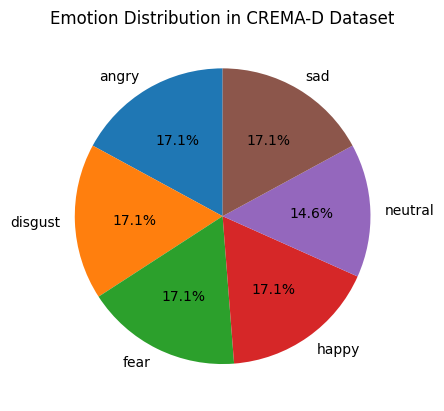

In [3]:
class_dist = stat.groupby(['class']).count()['file_name']
plt.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',startangle=90)
plt.title("Emotion Distribution in CREMA-D Dataset")
plt.show()

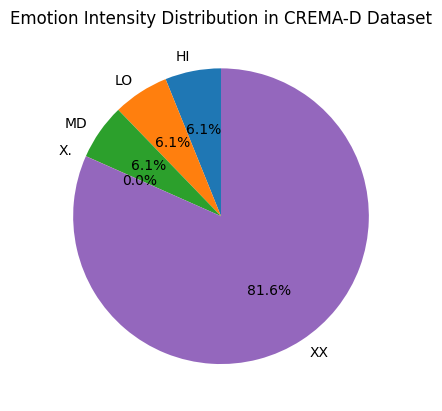

In [4]:
its_dist = stat.groupby(['Emo_Intensity']).count()['file_name']
plt.pie(its_dist,labels=its_dist.index,autopct='%1.1f%%',startangle=90)
plt.title("Emotion Intensity Distribution in CREMA-D Dataset")
plt.show()

In [3]:
pip install noisereduce

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opensmile

Note: you may need to restart the kernel to use updated packages.


In [6]:
import noisereduce as nr
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

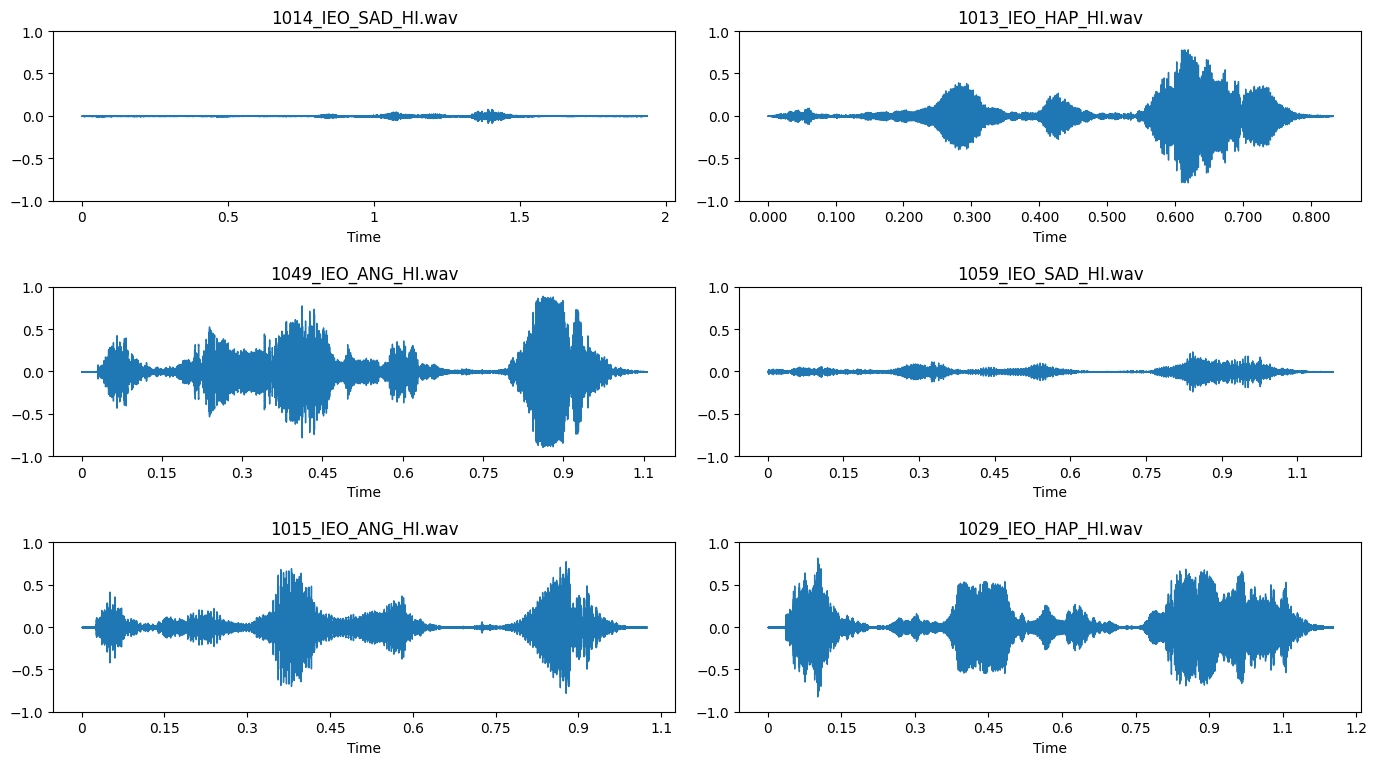

In [10]:
dpath = '/kaggle/input/cremad/AudioWAV'
labdict = {'ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral','SAD':'sad'}
wavlabs = dict()
plt.figure(figsize=(14, 10))
rwav = np.random.choice(os.listdir(dpath),500)
wavs = []
i = 0
for p in rwav:
    path = os.path.join(dpath,p)
    label = labdict[p.split('_')[2]]
    its = p.split('_')[3]
    if label in ['angry','neutral','happy','sad'] and its=='HI.wav':
        i+=1
        y,sr = librosa.load(path,sr=16000)
        wavs.append(p)
        ytrim,index = librosa.effects.trim(y,top_db=20)
        yclean = nr.reduce_noise(ytrim,sr)
        plt.subplot(4,2,i)
        plt.title(p)
        plt.ylim(-1,1)
        librosa.display.waveshow(yclean, sr=sr)
        if i==6:
            break
plt.tight_layout(pad=1.5)
plt.show()

In [11]:
import IPython.display as ipd
wav = wavs[3]
print(wav)
path = os.path.join(dpath,wav)
y,sr = librosa.load(path,sr=16000)
y = nr.reduce_noise(y,sr)
y,index = librosa.effects.trim(y,top_db=25)
ipd.Audio(y,rate=sr)

1059_IEO_SAD_HI.wav


In [12]:
print(wav)
path = os.path.join(dpath,wav)
y,sr = librosa.load(path,sr=16000)
ipd.Audio(y,rate=sr)

1059_IEO_SAD_HI.wav


In [14]:
dpath = '/kaggle/input/cremad/AudioWAV'
labdict = {'ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral','SAD':'sad'}
i = 0
feats = pd.DataFrame()
for p in tqdm.tqdm(os.listdir(dpath)):
    path = os.path.join(dpath,p)
    label = labdict[p.split('_')[2]]
    y,sr = librosa.load(path,sr=16000)
    ytrim,_ = librosa.effects.trim(y,top_db=20)
    yclean = nr.reduce_noise(ytrim,sr)
    sf.write('/kaggle/working/trimmed_audio.wav', yclean, sr)
    sml = smile.process_file('/kaggle/working/trimmed_audio.wav')
    sml.reset_index(drop=True,inplace=True)
    sml['label'] = label
    feats = pd.concat([feats, sml], ignore_index = True)
feats

 90%|████████▉ | 6674/7442 [18:46<02:21,  5.45it/s]/opt/conda/lib/python3.10/site-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
100%|██████████| 7442/7442 [21:16<00:00,  5.83it/s]


,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,0.283087,0.351695,0.114407,0.019516,0.086236,0.133450,0.066720,0.047213,0.113933,0.010054,...,0.626081,2.252254,2.276943,-19.236828,0.438872,92.671158,43.824638,91.460365,57.257088,disgust
1,0.450796,0.339744,0.666667,0.023399,0.030485,0.190735,0.007086,0.160250,0.167335,0.016857,...,0.578092,1.746136,1.748039,-19.999828,0.462072,85.607529,38.963768,74.271408,41.101089,happy
2,0.582389,0.271605,0.000000,0.108567,0.189416,0.266452,0.080849,0.077037,0.157886,0.022642,...,0.616435,3.013976,2.976359,19.027126,0.601453,105.442879,41.915794,116.730110,62.343582,happy
3,0.938659,0.348315,0.842697,0.195384,0.261150,0.392237,0.065766,0.131087,0.196853,0.076487,...,0.543531,2.502343,2.541978,-18.542135,0.677923,109.665680,53.580017,78.247658,37.373333,disgust
4,0.958477,0.364780,0.000000,0.086069,0.137500,0.252903,0.051431,0.115403,0.166835,0.037426,...,0.351511,2.328939,2.472584,-13.249281,0.737216,127.037125,41.492443,110.201286,50.369888,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0.986579,0.256198,0.000000,0.187007,0.303785,0.387124,0.116778,0.083339,0.200117,0.033847,...,0.636325,3.099806,3.043244,18.189360,0.565104,137.267578,67.798988,144.334518,60.653488,angry
7438,2.301252,0.051282,0.863248,0.247922,0.476041,0.770648,0.228119,0.294607,0.522726,0.016104,...,0.766714,1.862289,2.148709,-6.501959,0.519850,116.101166,59.045696,110.876350,58.675919,angry
7439,1.518607,0.365979,0.134021,0.120969,0.235736,0.600588,0.114767,0.364852,0.479620,0.011524,...,0.497689,2.436864,2.588179,-13.212930,0.694735,117.924759,45.889969,127.106728,57.104458,angry
7440,0.331285,0.243243,0.822394,0.015225,0.051348,0.135942,0.036122,0.084595,0.120717,0.010996,...,0.526080,2.200989,2.183082,19.591042,0.598791,83.836845,35.650146,96.719200,48.398067,sad


In [16]:
feats.isnull().sum().sum()

0

In [17]:
feats.to_csv('/kaggle/working/CREMA_D_OpenSMILE_Features_16khz_trim_then_NR.csv',index=False)

In [3]:
feats = pd.read_csv('/kaggle/input/crema-d-opensmile-all-emo-16khz-20db-trim-then-nr/CREMA_D_OpenSMILE_Features_16khz_trim_then_NR.csv')

In [19]:
x = feats.drop(['label'], axis=1)
y = feats['label']
le = LabelEncoder()
y2 = le.fit_transform(y)
trainX2, testX2, trainY2, testY2 = train_test_split(x, y, test_size=0.2, random_state=710,stratify=y)
lda = LinearDiscriminantAnalysis()
trainX2 = lda.fit_transform(trainX2, trainY2)
testX2 = lda.transform(testX2)
scaler = StandardScaler()
trainX2 = scaler.fit_transform(trainX2)
testX2 = scaler.transform(testX2)

In [12]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=False,onlypreprocess=False,hppms=None):
  x = df.drop(['label'], axis=1)
  y = np.array(df['label'])
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  if printres:
      print("Train test split done")
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if printres:
      print("Scaling done")
  if apply_LDA:
    trainX, testX, trainY, testY = trainX2.copy(),testX2.copy(),trainY2.copy(),testY2.copy()
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost' or name=='SVM':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
    if printres:
        print("SMOTE done")
  if onlypreprocess:
    return trainX,trainY,testX,testY
  if printres:
      print("Training model started")
  model.fit(trainX, trainY)
  if printres:
      print("Training model done")
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def train_test_model(trainX,testX,trainY,testY,le,model,name,apply_smote=False,printres=True,returnModelFiles=False):
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  model.fit(trainX, trainY)
  predictions = model.predict(testX)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  return acc

In [22]:
trainX2.var()

1.0000000000000002

Train test split done
Scaling done
Training model started
Training model done


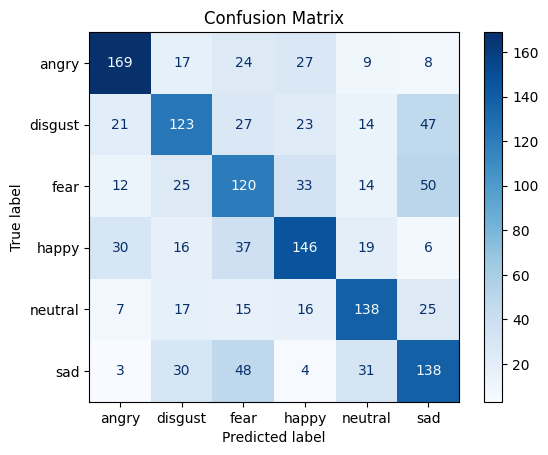


Logistic Regression Accuracy: 56.011%
              precision    recall  f1-score   support

       angry       0.70      0.67      0.68       254
     disgust       0.54      0.48      0.51       255
        fear       0.44      0.47      0.46       254
       happy       0.59      0.57      0.58       254
     neutral       0.61      0.63      0.62       218
         sad       0.50      0.54      0.52       254

    accuracy                           0.56      1489
   macro avg       0.56      0.56      0.56      1489
weighted avg       0.56      0.56      0.56      1489

CPU times: user 10min 38s, sys: 1min 50s, total: 12min 28s
Wall time: 3min 14s


In [24]:
%%time
lr_model = LogisticRegression(C=0.3,class_weight='balanced',max_iter=1500)
acc_lr = preprocess_split_train_test(feats,lr_model,'Logistic Regression',rs=710)

Train test split done
Scaling done
Training model started
Training model done


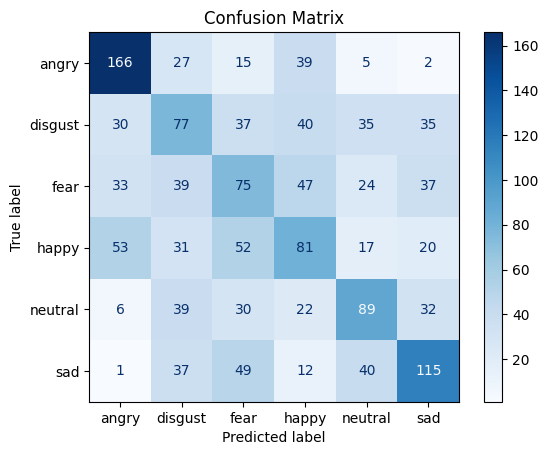


Decision Tree Accuracy: 40.497%
              precision    recall  f1-score   support

       angry       0.57      0.65      0.61       254
     disgust       0.31      0.30      0.31       254
        fear       0.29      0.29      0.29       255
       happy       0.34      0.32      0.33       254
     neutral       0.42      0.41      0.42       218
         sad       0.48      0.45      0.46       254

    accuracy                           0.40      1489
   macro avg       0.40      0.41      0.40      1489
weighted avg       0.40      0.40      0.40      1489



In [20]:
dt_model = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,min_samples_leaf=8,random_state=30)
acc_dt = preprocess_split_train_test(feats,dt_model,'Decision Tree',rs=205)

Train test split done
Scaling done
Training model started
Training model done


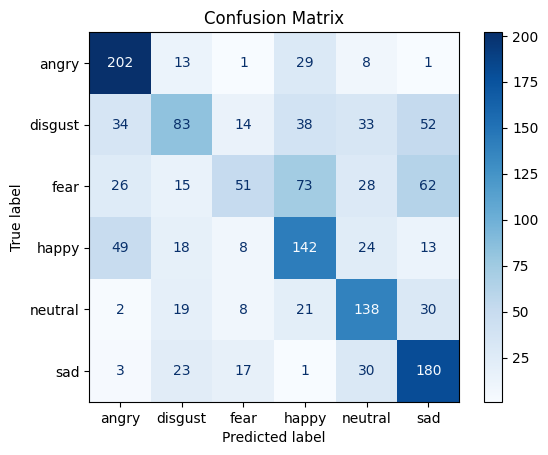


Random Forest Accuracy: 53.459%
              precision    recall  f1-score   support

       angry       0.64      0.80      0.71       254
     disgust       0.49      0.33      0.39       254
        fear       0.52      0.20      0.29       255
       happy       0.47      0.56      0.51       254
     neutral       0.53      0.63      0.58       218
         sad       0.53      0.71      0.61       254

    accuracy                           0.53      1489
   macro avg       0.53      0.54      0.51      1489
weighted avg       0.53      0.53      0.51      1489

CPU times: user 4min 43s, sys: 502 ms, total: 4min 43s
Wall time: 4min 43s


In [21]:
%%time
rf_model = RandomForestClassifier(n_estimators=700,random_state=24)
acc_rf = preprocess_split_train_test(feats,rf_model,'Random Forest',rs=205)

Train test split done
Scaling done
Training model started
Training model done


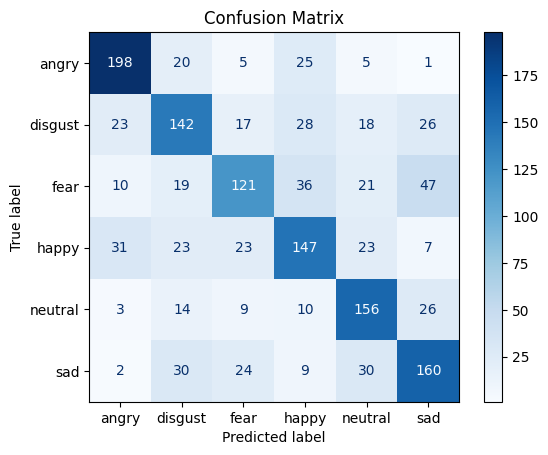


SVM Accuracy: 62.055%
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       254
           1       0.57      0.56      0.57       254
           2       0.61      0.48      0.53       254
           3       0.58      0.58      0.58       254
           4       0.62      0.72      0.66       218
           5       0.60      0.63      0.61       255

    accuracy                           0.62      1489
   macro avg       0.62      0.62      0.62      1489
weighted avg       0.62      0.62      0.62      1489

CPU times: user 17.5 s, sys: 3.55 s, total: 21 s
Wall time: 20.7 s


In [9]:
%%time
svm_model = cuSVC(C=2,kernel='rbf')
acc_svm = preprocess_split_train_test(feats,svm_model,'SVM',rs=80)

In [42]:
macc = 0
for k in range(3,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    acc_knn = preprocess_split_train_test(feats,knn_model,'KNN',rs=205,apply_LDA=False,printres=False)
    if acc_knn>macc:
        macc = acc_knn
        kop = k
        print(f"Best Accuracy = {macc*100:.3f}% at k={kop}")

Best Accuracy = 40.900% at k=3
Best Accuracy = 43.653% at k=4
Best Accuracy = 45.265% at k=5
Best Accuracy = 45.400% at k=6
Best Accuracy = 46.676% at k=7
Best Accuracy = 48.086% at k=8
Best Accuracy = 49.429% at k=10
Best Accuracy = 50.235% at k=11
Best Accuracy = 50.907% at k=12


Train test split done
Scaling done
Training model started
Training model done
Predicting done


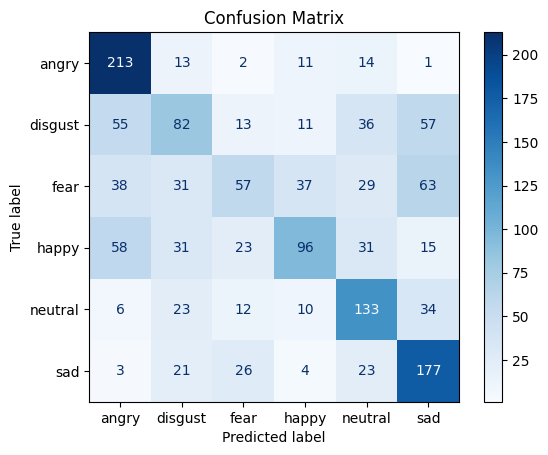


KNN Accuracy: 50.907%
              precision    recall  f1-score   support

       angry       0.57      0.84      0.68       254
     disgust       0.41      0.32      0.36       254
        fear       0.43      0.22      0.29       255
       happy       0.57      0.38      0.45       254
     neutral       0.50      0.61      0.55       218
         sad       0.51      0.70      0.59       254

    accuracy                           0.51      1489
   macro avg       0.50      0.51      0.49      1489
weighted avg       0.50      0.51      0.49      1489

CPU times: user 8.33 s, sys: 462 ms, total: 8.79 s
Wall time: 3.59 s


In [8]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=12,p=2)
acc_knn = preprocess_split_train_test(feats,knn_model,'KNN',rs=205)

In [18]:
%%time
st = time.time()
macc = 0
while True:
    rs = np.random.randint(0,1000)
    nb_model = GaussianNB()
    acc_nb = preprocess_split_train_test(feats,nb_model,'Naive Bayes',rs=rs,printres=False)
    if acc_nb>macc:
        macc = acc_nb
        print(f"{macc*100:.3f} - {rs}")
    en = time.time()
    if (en-st)>(60*5):
        break

43.049 - 212
43.989 - 560
44.056 - 524
44.527 - 925
44.661 - 692
45.265 - 999
45.332 - 274
45.870 - 175
CPU times: user 3min 45s, sys: 1min 16s, total: 5min 1s
Wall time: 5min 1s


Train test split done
Scaling done
Training model started
Training model done
Predicting done


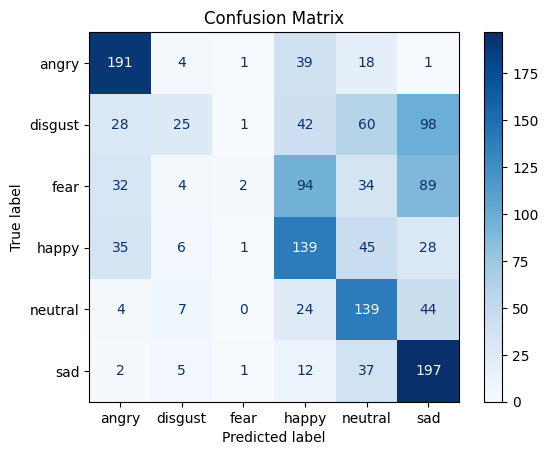


Naive Bayes Accuracy: 46.541%
              precision    recall  f1-score   support

       angry       0.65      0.75      0.70       254
     disgust       0.49      0.10      0.16       254
        fear       0.33      0.01      0.02       255
       happy       0.40      0.55      0.46       254
     neutral       0.42      0.64      0.50       218
         sad       0.43      0.78      0.55       254

    accuracy                           0.47      1489
   macro avg       0.45      0.47      0.40      1489
weighted avg       0.45      0.47      0.40      1489

CPU times: user 2.28 s, sys: 596 ms, total: 2.87 s
Wall time: 2.62 s


In [9]:
%%time
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(feats,nb_model,'Naive Bayes',rs=205,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


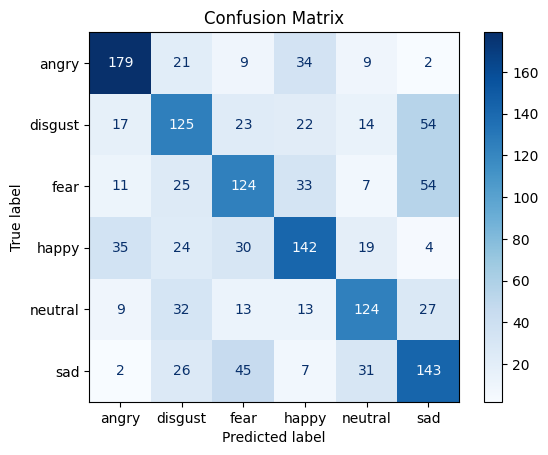


AdaBoost Accuracy: 56.212%
              precision    recall  f1-score   support

       angry       0.71      0.70      0.71       254
     disgust       0.49      0.49      0.49       255
        fear       0.51      0.49      0.50       254
       happy       0.57      0.56      0.56       254
     neutral       0.61      0.57      0.59       218
         sad       0.50      0.56      0.53       254

    accuracy                           0.56      1489
   macro avg       0.56      0.56      0.56      1489
weighted avg       0.56      0.56      0.56      1489

CPU times: user 54min 57s, sys: 8min 50s, total: 1h 3min 48s
Wall time: 17min 1s


In [29]:
%%time
ab_model = AdaBoostClassifier(estimator=lr_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(feats,ab_model,'AdaBoost',rs=710,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


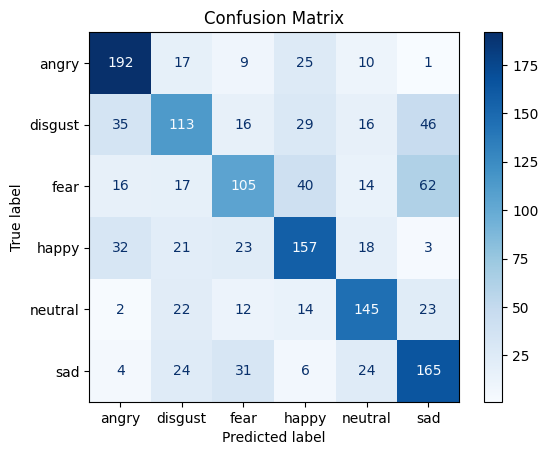


XGBoost Accuracy: 58.899%
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       254
           1       0.53      0.44      0.48       255
           2       0.54      0.41      0.47       254
           3       0.58      0.62      0.60       254
           4       0.64      0.67      0.65       218
           5       0.55      0.65      0.60       254

    accuracy                           0.59      1489
   macro avg       0.59      0.59      0.59      1489
weighted avg       0.58      0.59      0.58      1489

CPU times: user 1min 23s, sys: 1.18 s, total: 1min 24s
Wall time: 1min 12s


In [26]:
%%time
xgb_model = XGBClassifier(device='cuda')
acc_xgb = preprocess_split_train_test(feats,xgb_model,'XGBoost',rs=710,apply_LDA=False)

In [104]:
from cuml.svm import SVC as cuSVC
svc_model = cuSVC()
hppms = svc_model.get_params()
print(hppms)

{'handle': <pylibraft.common.handle.Handle object at 0x798fe1c3dcb0>, 'verbose': 4, 'output_type': 'input', 'C': 1, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': None, 'class_weight': None, 'multiclass_strategy': 'ovo'}


In [1]:
hpr = []
iters = 20
max_acc = 0
best_params,phist = dict(),dict()
st0 = time.time()
for k in range(iters):
    st = time.time()
    '''model_params = {
    'C': 10**np.random.uniform(np.log10(0.1), np.log10(100)),
    'kernel': np.random.choice(['linear','poly','rbf','sigmoid']),
    'gamma': 10**np.random.uniform(np.log10(0.1), np.log10(100)),
    'coef0': 10**np.random.uniform(np.log10(0.01), np.log10(10)),
    'class_weight': np.random.choice(['balanced',None]),
    'probability': np.random.choice([True,False]),
    'multiclass_strategy': np.random.choice(['ovo','ovr']),
    'random_state': np.random.randint(0, 1000),
    }'''
    model_params = {
    'C': 10**np.random.uniform(np.log10(0.01), np.log10(10)),
    'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.0003)),
    'coef0': 10**np.random.uniform(0, np.log10(0.1)),
    'class_weight': np.random.choice(['balanced',None]),
    'multiclass_strategy': np.random.choice(['ovo','ovr']),
    'random_state': np.random.randint(0, 1000),
    }
    prep_params = dict({'rs':np.random.randint(0, 1000),
                   'apply_smote':np.random.choice([True,False])})
    all_params = model_params.update(prep_params)
    fparams = frozenset(all_params.items())
    svm_model = cuSVC(**model_params)
    print(f"Iter No. - {k}")
    print(f"Model Params = {model_params}")
    print(f"Preprocessing Params = {prep_params}")
    acc_svm,(model_params,prep_params) = preprocess_split_train_test(feats,svm_model,'SVM',**prep_params,apply_LDA=False,printres=False,hppms=(model_params,prep_params))
    en = time.time()
    tm = en-st
    tm0 = en-st0
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
    phist[fparams] = acc_svm
    if acc_svm>max_acc:
        max_acc = acc_svm
        best_params = all_params
        best_iter = k
    print(f"\nCurrent Accuracy = {acc_svm*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

SyntaxError: invalid syntax (2408548420.py, line 6)

In [ ]:
#%%time
mparams = {'C': 3.0591390382253287, 'gamma': 9.783544948648503e-05, 'coef0': 0.24372568368643766,
           'class_weight': None, 'multiclass_strategy': 'ovr', 'random_state': 537}
svm_model = cuSVC(**mparams)
acc_svm = preprocess_split_train_test(feats,svm_model,'SVM',rs=502,apply_LDA=False)

In [7]:
hpr = []
iters = 20
max_acc = 0
best_params,phist = dict(),dict()
st0 = time.time()
for k in range(iters):
    st = time.time()
    model_params = {
    'C': 10**np.random.uniform(np.log10(1), np.log10(10)),
    'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.0003)),
    'coef0': np.random.uniform(0, 0.1),
    'class_weight': np.random.choice(['balanced',None]),
    'multiclass_strategy': np.random.choice(['ovo','ovr']),
    'random_state': np.random.randint(0, 1000),
    }
    prep_params = {'rs':502,
                   'apply_smote':np.random.choice([True,False])}
    all_params = {**model_params, **prep_params}
    fparams = frozenset(all_params.items())
    svm_model = cuSVC(cache_size=100,**model_params)
    print(f"Iter No. - {k}")
    print(f"Model Params = {model_params}")
    print(f"Preprocessing Params = {prep_params}")
    acc_svm,(model_params,prep_params) = preprocess_split_train_test(feats,svm_model,'SVM',**prep_params,apply_LDA=False,printres=False,hppms=(model_params,prep_params))
    en = time.time()
    tm = en-st
    tm0 = en-st0
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
    phist[fparams] = acc_svm
    if acc_svm>max_acc:
        max_acc = acc_svm
        best_params = all_params
        best_iter = k
    print(f"\nCurrent Accuracy = {acc_svm*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'C': 4.523133912419896, 'gamma': 0.00019458206034371847, 'coef0': 0.08893378623107208, 'class_weight': None, 'multiclass_strategy': 'ovr', 'random_state': 640}
Preprocessing Params = {'rs': 502, 'apply_smote': True}
Train test split done
Scaling done
SMOTE done
Training model started
Training model done
Time taken = 0 min 43 sec
Total Time taken = 0 min 43 sec

Current Accuracy = 61.79%
Best Accuracy = 61.79% at iter=0
Best Params Found so far = {'C': 4.523133912419896, 'gamma': 0.00019458206034371847, 'coef0': 0.08893378623107208, 'class_weight': None, 'multiclass_strategy': 'ovr', 'random_state': 640, 'rs': 502, 'apply_smote': True}

Iter No. - 1
Model Params = {'C': 5.229915556903444, 'gamma': 6.859837660398692e-05, 'coef0': 0.09542438005343216, 'class_weight': None, 'multiclass_strategy': 'ovo', 'random_state': 988}
Preprocessing Params = {'rs': 502, 'apply_smote': True}
Train test split done
Scaling done
SMOTE done
Training model started
Training model

Train test split done
Scaling done
Training model started
Training model done


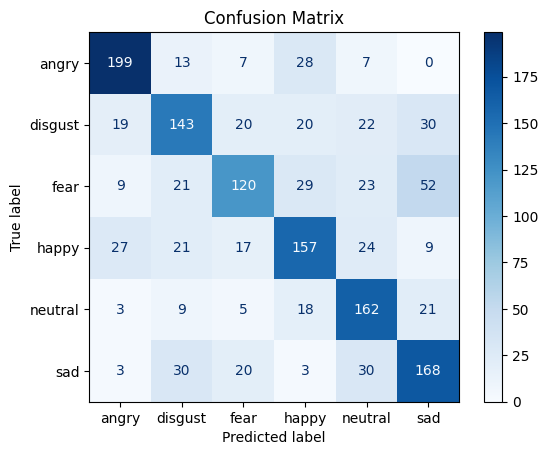


SVM Accuracy: 63.734%
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       254
           1       0.60      0.56      0.58       254
           2       0.63      0.47      0.54       254
           3       0.62      0.62      0.62       255
           4       0.60      0.74      0.67       218
           5       0.60      0.66      0.63       254

    accuracy                           0.64      1489
   macro avg       0.64      0.64      0.64      1489
weighted avg       0.64      0.64      0.63      1489

CPU times: user 17.5 s, sys: 4.84 s, total: 22.3 s
Wall time: 22 s


In [11]:
%%time
mparams = {'C': 2.1889685016100344, 'gamma': 0.00010978835863041679, 'coef0': 0.03516846316270642, 
           'class_weight': None, 'multiclass_strategy': 'ovr', 'random_state': 275}
svm_model = cuSVC(cache_size=100,**mparams)
acc_svm = preprocess_split_train_test(feats,svm_model,'SVM',rs=502,apply_LDA=False)

In [4]:
hpr = []
iters = 20
max_acc = 0
best_params,phist = dict(),dict()
st0 = time.time()
for k in range(iters):
    st = time.time()
    model_params = {
    'C': 10**np.random.uniform(np.log10(1), np.log10(6)),
    'gamma': 10**np.random.uniform(np.log10(0.00005), np.log10(0.000175)),
    'coef0': np.random.uniform(0, 0.1),
    'class_weight': np.random.choice(['balanced',None]),
    'multiclass_strategy': np.random.choice(['ovo','ovr']),
    'random_state': np.random.randint(0, 1000),
    }
    prep_params = {'rs':502,
                   'apply_smote':np.random.choice([True,False])}
    all_params = {**model_params, **prep_params}
    fparams = frozenset(all_params.items())
    svm_model = cuSVC(cache_size=100,**model_params)
    print(f"Iter No. - {k}")
    print(f"Model Params = {model_params}")
    print(f"Preprocessing Params = {prep_params}")
    acc_svm,(model_params,prep_params) = preprocess_split_train_test(feats,svm_model,'SVM',**prep_params,apply_LDA=False,printres=False,hppms=(model_params,prep_params))
    en = time.time()
    tm = en-st
    tm0 = en-st0
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    print(f"Total Time taken = {int(tm0/60)} min {int(tm0%60)} sec")
    phist[fparams] = acc_svm
    if acc_svm>max_acc:
        max_acc = acc_svm
        best_params = all_params
        best_iter = k
    print(f"\nCurrent Accuracy = {acc_svm*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}% at iter={best_iter}")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'C': 4.007986554422021, 'gamma': 7.212883839897948e-05, 'coef0': 0.048248862214507776, 'class_weight': 'balanced', 'multiclass_strategy': 'ovr', 'random_state': 117}
Preprocessing Params = {'rs': 502, 'apply_smote': True}
Train test split done
Scaling done
SMOTE done
Training model started
Training model done
Time taken = 0 min 33 sec
Total Time taken = 0 min 33 sec

Current Accuracy = 61.92%
Best Accuracy = 61.92% at iter=0
Best Params Found so far = {'C': 4.007986554422021, 'gamma': 7.212883839897948e-05, 'coef0': 0.048248862214507776, 'class_weight': 'balanced', 'multiclass_strategy': 'ovr', 'random_state': 117, 'rs': 502, 'apply_smote': True}

Iter No. - 1
Model Params = {'C': 3.732871081486728, 'gamma': 8.790953210668864e-05, 'coef0': 0.09880609799442214, 'class_weight': 'balanced', 'multiclass_strategy': 'ovo', 'random_state': 145}
Preprocessing Params = {'rs': 502, 'apply_smote': True}
Train test split done
Scaling done
SMOTE done
Training model star

In [13]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df = pd.DataFrame(data)
df = df.reindex(sorted(df.columns), axis=1)
df = df[[col for col in sorted(df.columns) if col != 'accuracy'] + ['accuracy']]
df.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df

,C,apply_smote,class_weight,coef0,gamma,multiclass_strategy,random_state,rs,accuracy
0,1.667322,True,None,0.004331,0.000141,ovr,81,502,0.633983
1,3.205095,False,None,0.003454,0.000070,ovr,869,502,0.633983
2,1.336693,True,balanced,0.094135,0.000134,ovr,236,502,0.631968
3,3.241674,True,balanced,0.004785,0.000098,ovo,653,502,0.630625
4,2.712477,True,None,0.095064,0.000149,ovo,950,502,0.629953
5,2.943460,True,balanced,0.001683,0.000141,ovo,463,502,0.629953
6,3.011544,True,None,0.063650,0.000111,ovo,35,502,0.627267
7,1.130849,False,None,0.054697,0.000093,ovr,715,502,0.624580
8,2.705887,False,balanced,0.041776,0.000113,ovr,893,502,0.623909
9,2.384071,True,balanced,0.004380,0.000134,ovo,525,502,0.623237


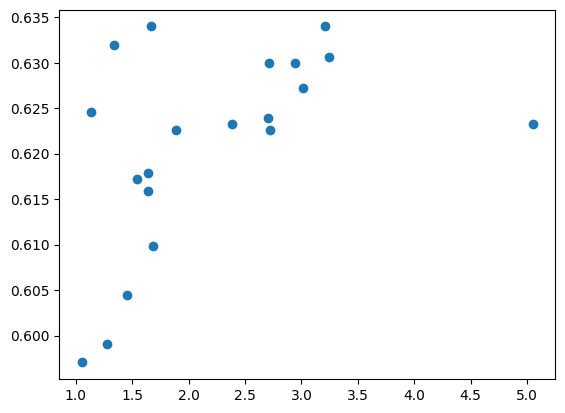

In [16]:
plt.scatter(x=df['C'],y=df['accuracy'])

In [15]:
numerical_features = df.iloc[:,:-1].select_dtypes(include=['int64', 'float64','bool'])
categorical_features = df.select_dtypes(include=['object', 'category'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

C               0.488340
gamma           0.418529
apply_smote    -0.084186
coef0          -0.254880
random_state   -0.263805
rs                   NaN
dtype: float64


In [11]:
categorical_features

,class_weight,multiclass_strategy
0,None,ovr
1,None,ovr
2,balanced,ovo
3,None,ovr
4,None,ovo
5,None,ovr
6,balanced,ovo
7,balanced,ovr
8,None,ovr
9,None,ovr


In [4]:
import concurrent.futures, warnings
warnings.filterwarnings("ignore")
from scipy.stats import randint, uniform
hpr = []
iters = 10
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Training Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(feats,xgb_model,'XGBoost',apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")

Iter No. - 0
Model Params = {'learning_rate': 0.09228644957074504, 'n_estimators': 60, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.7459453639217332, 'subsample': 0.9472324159388188, 'colsample_bytree': 0.9223005529999886, 'reg_alpha': 0.9387866105258564, 'reg_lambda': 0.6478229727450998, 'scale_pos_weight': 8.215460994151812, 'random_state': 878}
Training Params = {'apply_smote': False, 'rs': 208}

Train test split done
Scaling done
Training model started
Training model done
Time taken = 1 min 30 sec

Current Accuracy = 58.63%
Best Accuracy = 58.63%
Best Params Found so far = {'learning_rate': 0.09228644957074504, 'n_estimators': 60, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 0.7459453639217332, 'subsample': 0.9472324159388188, 'colsample_bytree': 0.9223005529999886, 'reg_alpha': 0.9387866105258564, 'reg_lambda': 0.6478229727450998, 'scale_pos_weight': 8.215460994151812, 'random_state': 878, 'apply_smote': False, 'rs': 208}

Iter No. - 1
Model Params = {'learning_rate': 0.

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


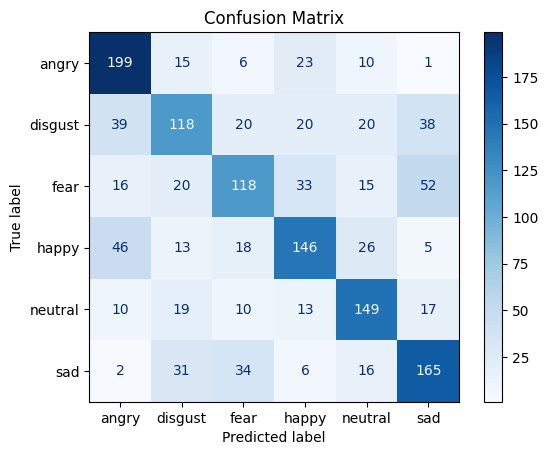


XGBoost Accuracy: 60.107%
              precision    recall  f1-score   support

           0       0.64      0.78      0.70       254
           1       0.55      0.46      0.50       255
           2       0.57      0.46      0.51       254
           3       0.61      0.57      0.59       254
           4       0.63      0.68      0.66       218
           5       0.59      0.65      0.62       254

    accuracy                           0.60      1489
   macro avg       0.60      0.60      0.60      1489
weighted avg       0.60      0.60      0.60      1489

CPU times: user 52.7 s, sys: 1.13 s, total: 53.8 s
Wall time: 41.8 s


In [10]:
%%time
mparams = {'learning_rate': 0.13891415929020914, 'n_estimators': 145, 'max_depth': 5, 
           'min_child_weight': 9, 'gamma': 0.9310956170734062, 'subsample': 0.8629742529626865, 
           'colsample_bytree': 0.5104337019468103, 'reg_alpha': 0.9170145974038575, 'reg_lambda': 0.42644617040014354,
           'scale_pos_weight': 4.630387232054437, 'random_state': 751}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(feats,xgb_model,'XGBoost',rs=849,apply_smote=True,apply_LDA=False)